We start with importing the necessary python libraries that we are going to work with.

In [1]:
# import python libraries
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import shutil
from matplotlib import pyplot as plt

# import cea-specific libraries
import cea.api # this is the API to call scripts in CEA, such as the data-helper, radiation engine, demand,...
import cea.inputlocator # this module provides paths to input and output files according to the CEA folder structure
import cea.config # this module let's us interact with the CEA configuration

cea.api: loading cea_script: <cea html>
cea.api: loading cea_script: <cea update-naming>
cea.api: loading cea_script: <cea graphviz>
cea.api: loading cea_script: <cea test>
cea.api: loading cea_script: <cea dbf-to-excel-to-dbf>
cea.api: loading cea_script: <cea glossary>
cea.api: loading cea_script: <cea dashboard>
cea.api: loading cea_script: <cea plots>
cea.api: loading cea_script: <cea benchmark-graphs>
cea.api: loading cea_script: <cea thermal-network>
cea.api: loading cea_script: <cea install-arcgis>
cea.api: loading cea_script: <cea plots-scenario-comparisons>


C:\Users\Gabriel\Documents\CityEnergyAnalyst\Dependencies\Python\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning:

Falling back to the python version of hypervolume module. Expect this to be very slow.



cea.api: loading cea_script: <cea solar-collector>
cea.api: loading cea_script: <cea install-grasshopper>
cea.api: loading cea_script: <cea compile>
cea.api: loading cea_script: <cea network-layout>
cea.api: loading cea_script: <cea sensitivity-demand-simulate>
cea.api: loading cea_script: <cea excel-to-shapefile>
cea.api: loading cea_script: <cea shapefile-to-excel>
cea.api: loading cea_script: <cea list-demand-graphs-fields>
cea.api: loading cea_script: <cea workflow>
cea.api: loading cea_script: <cea extract-reference-case>
cea.api: loading cea_script: <cea trace-inputlocator>
cea.api: loading cea_script: <cea lake-potential>
cea.api: loading cea_script: <cea optimization>
cea.api: loading cea_script: <cea sewage-potential>
cea.api: loading cea_script: <cea supply-system-simulation>
cea.api: loading cea_script: <cea thermal-network-optimization>
cea.api: loading cea_script: <cea photovoltaic>
cea.api: loading cea_script: <cea operation-costs>
cea.api: loading cea_script: <cea demand

As a next step, we are going to set up our configuration to the desired case study. I am going to use the "reference-case-cooling" that ships with the CEA source code. Because CEA provides a script to extract the different reference cases, we can call this script via the API directly in jupyter notebooks. 

In [2]:
# create the path to the destination folder
path_to_folder_for_blog = os.path.expandvars(r'${userprofile}/Documents/GitHub/blog')
# extract the reference-case-cooling to the destination folder
cea.api.extract_reference_case(destination=path_to_folder_for_blog, case='cooling')

City Energy Analyst version 2.18.1
Running `cea extract-reference-case` with the following parameters:
- extract-reference-case:destination = C:\Users\Gabriel\Documents\GitHub\blog
  (default: C:\)
- extract-reference-case:case = cooling
  (default: open)

---------------------------------------
Script completed. Execution time: 0.05s


After I have extracted my case study, I have to make sure that the configuration for the other scripts points to the right folder. Therefore I am setting the project path and scenario name to the correct values. Setting the configuration can be done by manipulating the cea.config file with a text editor or also directly in jupyter via the `config.Configuration` object.


In [3]:
path_to_project = os.path.join(path_to_folder_for_blog, 'reference-case-cooling') # construct the path to the project

config = cea.config.Configuration() # load the configuration
config.project = path_to_project # set the path to the project
config.scenario_name = 'baseline' # set the scenario name
print(config.scenario) # print the scenario to check the changes
config.save() # save the changes to the cea.config file

C:\Users\Gabriel\Documents\GitHub\blog\reference-case-cooling\baseline


Now, we are ready for a run-through of the usual simulation steps for the district energy demand. They are:
- Running the data-helper to set up our building model parameters
- Running the radiation engine to quantify the solar heat gains of the buildings
- Running the energy demand simulation

The input into all scripts called via the CEA API is the configuration object. On my laptop it took around 10 minutes to run the scripts

In [4]:
cea.api.data_helper(region='SG') # run the data-helper script
cea.api.radiation_daysim(weather='Singapore') # run the radiation engine
cea.api.demand(weather='Singapore') # run the building energy demand simulation

City Energy Analyst version 2.18.1
Running `cea data-helper` with the following parameters:
- general:scenario = C:\Users\Gabriel\Documents\GitHub\blog\reference-case-cooling\baseline
  (default: C:\reference-case-open\baseline)
- data-helper:region = SG
  (default: CH)
- data-helper:databases = ['comfort', 'architecture', 'HVAC', 'internal-loads', 'supply', 'restrictions', 'technology']
  (default: ['comfort', 'architecture', 'HVAC', 'internal-loads', 'supply', 'restrictions', 'technology'])
Running data-helper with scenario = C:\Users\Gabriel\Documents\GitHub\blog\reference-case-cooling\baseline
Running data-helper with archetypes = ['comfort', 'architecture', 'HVAC', 'internal-loads', 'supply', 'restrictions', 'technology']

---------------------------------------
Script completed. Execution time: 4.55s
City Energy Analyst version 2.18.1
Running `cea radiation-daysim` with the following parameters:
- general:scenario = C:\Users\Gabriel\Documents\GitHub\blog\reference-case-cooling\ba

	isolation_daysim: rad.sensor_file_path: c:\users\gabriel\appdata\local\temp\points_0.pts
Starting Daysim simulation starts for buildings [u'B001', u'B002', u'B003', u'B004', u'B005', u'B006', u'B007', u'B008', u'B009', u'B010']
Total number of sensors:  8073
Executing epw2wea
Executing radfiles2daysim
Writing radiance parameters
Executing gen_dc
Executing ds_illum
Evaluating illumination per sensor
Removing results folder
Writing results to disk
Daysim simulation finished in 10.06 mins

-----------------------------------------
Script completed. Execution time: 613.64s
City Energy Analyst version 2.18.1
Running `cea demand` with the following parameters:
- general:scenario = C:\Users\Gabriel\Documents\GitHub\blog\reference-case-cooling\baseline
  (default: C:\reference-case-open\baseline)
- general:weather = c:\users\gabriel\documents\cityenergyanalyst\cityenergyanalyst\cea\databases\weather\Singapore.epw
  (default: c:\users\gabriel\documents\cityenergyanalyst\cityenergyanalyst\cea\d

Now, we will use some python functionalities to create a new scenario by copying the files of the baseline scenario, modify some building occupancy schedules, and comparing the simulated energy demand results.

In [5]:
new_scenario_name = 'modified-occupancy-schedules' # the new scenario name
path_to_new_scenario = os.path.join(path_to_project, new_scenario_name) # create the destination path for copying the baseline scenario

path_to_baseline = os.path.join(path_to_project, 'baseline')

shutil.copytree(path_to_baseline, path_to_new_scenario) # copy the all files from the baseline to the new scenario

Part of the CEA building-properties inputs are the various schedules that determine the occupant presence, ventilation rate, electrical appliance use, etc.
These schedules are created based on the region-specific archetypes database during a demand simulation and saved to a CSV file, if they are not provided by the user. 

With the help of the CEA `inputlocator` we are going to read these building schedule files (they have been created during the baseline simulation and copied with the above code) and visualize them.

The various colums contain information about:

- `Ea` : Electrical appliance use
- `Ed` : Electrical energy demand of data centers
- `El` : Electrical lighting use
- `Epro` : Electrical process energy use
- `Qhpro` : Thermal process energy use
- `Qs` : Sensible heat gains from occupants
- `Vw` : Fresh water use
- `Vww` : Hot water use
- `X` : Latent heat gains (humidity gains) from occupants
- `people` : Occupant presence
- `ve` : Required ventilation rate due to occupant presence

In [6]:
inputlocator = cea.inputlocator.InputLocator(scenario=path_to_new_scenario) # the input for the inputlocator is the path to the scenario
buildings = inputlocator.get_zone_building_names() # get all building names in scenario

building_schedule_path = inputlocator.get_building_schedules(buildings[0]) # the path to the first building schedules file
df_schedules = pd.read_csv(building_schedule_path) # use pandas to read the CSV file into a DataFrame

df_schedules # print the DataFrame

DEBUG:fiona:Creating a not-responsible GDALEnv in drivers()
DEBUG:Fiona:GDAL_DATA: C:\Users\Gabriel\Documents\CityEnergyAnalyst\Dependencies\Python\Library\share\gdal
DEBUG:Fiona:PROJ_LIB: C:\Users\Gabriel\Documents\CityEnergyAnalyst\Dependencies\Python\Library\share
DEBUG:Fiona:GDAL_DATA: C:\Users\Gabriel\Documents\CityEnergyAnalyst\Dependencies\Python\Library\share\gdal
DEBUG:Fiona:PROJ_LIB: C:\Users\Gabriel\Documents\CityEnergyAnalyst\Dependencies\Python\Library\share
DEBUG:Fiona:Got coordinate system
DEBUG:Fiona:Got coordinate system
DEBUG:Fiona:Index: 0
DEBUG:fiona.collection:Flushed buffer
DEBUG:fiona.collection:Stopped session


,Ea,Ed,El,Epro,Qcre,Qhpro,Qs,Vw,Vww,X,people,ve
0,20353.61569,0.0,20353.61569,0.0,0.0,0.0,1023.0,0.00000,0.00000,1023.0,1023.0,1023.0
1,16282.89255,0.0,16282.89255,0.0,0.0,0.0,1023.0,0.00000,0.00000,1023.0,1023.0,1023.0
2,16282.89255,0.0,16282.89255,0.0,0.0,0.0,1023.0,0.00000,0.00000,1023.0,1023.0,1023.0
3,16282.89255,0.0,16282.89255,0.0,0.0,0.0,1023.0,7.10462,7.10462,1023.0,1023.0,1023.0
4,16282.89255,0.0,16282.89255,0.0,0.0,0.0,1023.0,7.10462,7.10462,1023.0,1023.0,1023.0
5,16282.89255,0.0,16282.89255,0.0,0.0,0.0,1023.0,7.10462,7.10462,1023.0,1023.0,1023.0
6,20353.61569,0.0,20353.61569,0.0,0.0,0.0,1023.0,113.67393,113.67393,1023.0,1023.0,1023.0
7,28495.06196,0.0,28495.06196,0.0,0.0,0.0,921.0,99.46469,99.46469,921.0,921.0,921.0
8,28495.06196,0.0,28495.06196,0.0,0.0,0.0,409.0,71.04620,71.04620,409.0,409.0,409.0
9,28495.06196,0.0,28495.06196,0.0,0.0,0.0,256.0,56.83696,56.83696,256.0,256.0,256.0


We can quickly visualize the data by plotting the first week of some schedules 

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'C:\\Users\\Gabriel\\Anaconda2\\envs\\popt\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


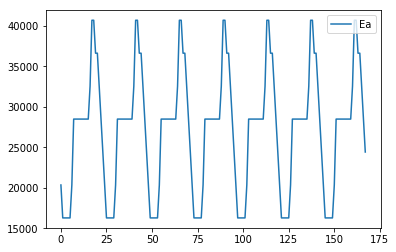

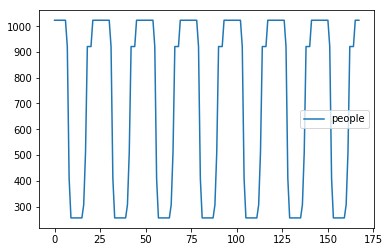

In [7]:
df_schedules['Ea'][0:168].plot() # visualize 1 week of electrical appliance schedule
plt.legend()
plt.show()
df_schedules['people'][0:168].plot() # visualize 1 week of occupant presence schedule
plt.legend()
plt.show()

Next, I am going to introduce some randomness (or stochasticity) to the schedules by multiplying each value with a factor sampled from a normal distribution centered around 1 (`mu = 1`) with a standard distribution of 5% (`sigma = 0.05`).

Such random factors can be obtaind with `sigma * np.random.randn(...) + mu`

https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html

We can test and visualize how this looks like for our schedules.

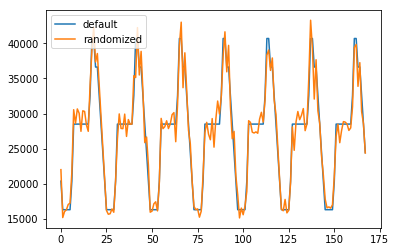

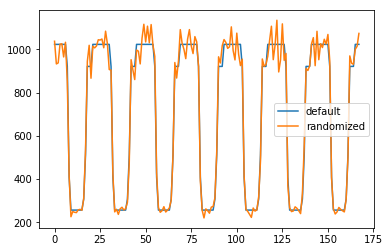

In [8]:
mu = 1.0
sigma = 0.05

df_schedules['Ea'][0:168].plot(label='default') # visualize 1 week of electrical appliance schedule
df_schedules['Ea'] = df_schedules['Ea'] * (sigma * np.random.randn(8760) + mu) # randomize the schedule
df_schedules['Ea'][0:168].plot(label='randomized')
plt.legend()
plt.show()

df_schedules['people'][0:168].plot(label='default') # visualize 1 week of occupant presence schedule
df_schedules['people'] = df_schedules['people'] * (sigma * np.random.randn(8760) + mu) # randomize the schedule
df_schedules['people'][0:168].plot(label='randomized')
plt.legend()
plt.show()

Now, I am simply going to randomize all schedules of all buildings in a nested `for` loop by reading, modifying and saving, the schedules again.
When I save the schedules from DataFrames back to CSV I set `index=False` to comply with the default file format. However, the files should also work fine with CEA if they have some additional columns, such as an index. They will just be ignored.

In [9]:
buildings = inputlocator.get_zone_building_names() # get all building names in scenario

for building in buildings:
    
    building_schedule_path = inputlocator.get_building_schedules(building) # the path to the building schedules file
    df_schedules = pd.read_csv(building_schedule_path) # use pandas to read the CSV file into a DataFrame
    
    for schedule in df_schedules.keys(): # iterate over all columns
        
        df_schedules[schedule] = df_schedules[schedule] * (sigma * np.random.randn(8760) + mu) # randomize the schedule

    df_schedules.to_csv(building_schedule_path, index=False) # save the schedules after modification

DEBUG:fiona:Creating a not-responsible GDALEnv in drivers()
DEBUG:Fiona:GDAL_DATA: C:\Users\Gabriel\Documents\CityEnergyAnalyst\Dependencies\Python\Library\share\gdal
DEBUG:Fiona:PROJ_LIB: C:\Users\Gabriel\Documents\CityEnergyAnalyst\Dependencies\Python\Library\share
DEBUG:Fiona:GDAL_DATA: C:\Users\Gabriel\Documents\CityEnergyAnalyst\Dependencies\Python\Library\share\gdal
DEBUG:Fiona:PROJ_LIB: C:\Users\Gabriel\Documents\CityEnergyAnalyst\Dependencies\Python\Library\share
DEBUG:Fiona:Got coordinate system
DEBUG:Fiona:Got coordinate system
DEBUG:Fiona:Index: 0
DEBUG:fiona.collection:Flushed buffer
DEBUG:fiona.collection:Stopped session


Because we do not want to change other building properties and because the schedules do not have an impact on the solar heat gains, I can now already run the energy demand simulation for my modified case study.

In [10]:
cea.api.demand(scenario=path_to_new_scenario, weather='Singapore') # run the demand simulation of the new scenario

City Energy Analyst version 2.18.1
Running `cea demand` with the following parameters:
- general:scenario = C:\Users\Gabriel\Documents\GitHub\blog\reference-case-cooling\modified-occupancy-schedules
  (default: C:\reference-case-open\baseline)
- general:weather = c:\users\gabriel\documents\cityenergyanalyst\cityenergyanalyst\cea\databases\weather\Singapore.epw
  (default: c:\users\gabriel\documents\cityenergyanalyst\cityenergyanalyst\cea\databases\weather\Zug.epw)
- general:multiprocessing = True
  (default: True)
- general:number-of-cpus-to-keep-free = 1
  (default: 1)
- demand:buildings = []
  (default: [])
- demand:loads-output = []
  (default: [])
- demand:massflows-output = []
  (default: [])
- demand:temperatures-output = []
  (default: [])
- demand:resolution-output = hourly
  (default: hourly)
- demand:format-output = csv
  (default: csv)
- demand:use-dynamic-infiltration-calculation = False
  (default: False)
- demand:use-stochastic-occupancy = False
  (default: False)
- deman

Now let's compare the district energy demand results of our two case studies.
For this simple example, I'm just going to look at the `Total_demand.csv` file that compiles a bunch of data for the district from the individual building demand output files.

An interesting analysis would e.g., be to look at the differences in cumulative annual energy demands and peak power demands. We do not expect to see differences in annual energy demand, because the stochasticity factor introduced is normally distributed around 1 and deviations towards higher and lower energy consumption should balance out. However, we do expect to see some deviations in peak loads, but how much?

The columns I'm going to look at are:

- `QC_sys_MWhyr` the total annual cooling demand
- `QC_sys0_kW` the peak cooling demand

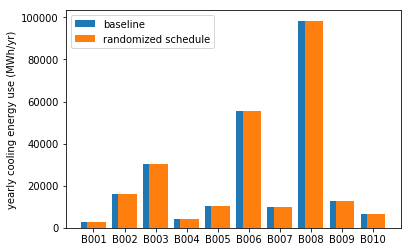

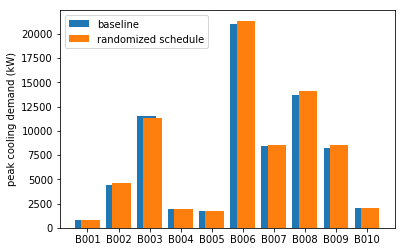

In [11]:
# get the new total demand file
inputlocator_new = cea.inputlocator.InputLocator(scenario=path_to_new_scenario)
total_demand_path_random = inputlocator_new.get_total_demand()
df_total_demand_random = pd.read_csv(total_demand_path_random, index_col='Name')

# get the baseline total demand file
inputlocator_baseline = cea.inputlocator.InputLocator(scenario=path_to_baseline)
total_demand_path_baseline = inputlocator_baseline.get_total_demand()
df_total_demand_baseline = pd.read_csv(total_demand_path_baseline, index_col='Name')

# plot the yearly cooling energy demand
fig, ax = plt.subplots()
x_data = np.arange(len(df_total_demand_baseline.index))
ax.bar(x_data-0.1, df_total_demand_baseline['QC_sys_MWhyr'], width=0.6, label='baseline')
ax.bar(x_data+0.1, df_total_demand_random['QC_sys_MWhyr'], width=0.6, label='randomized schedule')
ax.set_xticks(x_data)
ax.set_xticklabels(df_total_demand_baseline.index)
plt.ylabel('yearly cooling energy use (MWh/yr)')
plt.legend()
plt.show()

# plot the peak cooling energy demand
fig, ax = plt.subplots()
ax.bar(x_data-0.1, df_total_demand_baseline['QC_sys0_kW'], width=0.6, label='baseline')
ax.bar(x_data+0.1, df_total_demand_random['QC_sys0_kW'], width=0.6, label='randomized schedule')
ax.set_xticks(x_data)
ax.set_xticklabels(df_total_demand_baseline.index)
plt.ylabel('peak cooling demand (kW)')
plt.legend()
plt.show()

Interestingly, the buildings' peak cooling loads are affected in different ways...
There seem to be lot's of research opportunities.